In [1]:
#  ! pip install -r packages.txt -i https://pypi.tuna.tsinghua.edu.cn/simple


In [1]:
%matplotlib inline
import os
from os.path import join as pjoin
from tifffile import imread, imwrite
import numpy as np
import shutil
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import cv2
from tqdm import tqdm
from wf_utils import *

In [2]:
### Set the file path

# path_0: including one-day recording files
# path_1: including every stimuli
path_0 = "Z:\\WF_VC_liuzhaoxi\\23.10.20_G360_gp4.3"
path_1_ = os.listdir(path_0)
# 筛选出文件夹
path_1 = [folder for folder in path_1_ if os.path.isdir(pjoin(path_0, folder))]
path_all = []
for path in path_1:
    path_all.append(pjoin(path_0, path))

print('All the file path:\n'+str(path_all))


All the file path:
['Z:\\WF_VC_liuzhaoxi\\23.10.20_G360_gp4.3\\retinotopy_10x4', 'Z:\\WF_VC_liuzhaoxi\\23.10.20_G360_gp4.3\\rf68']


In [3]:
### re-organize files

for path in path_all:
    if not os.path.exists(pjoin(path, 'raw')):
        os.mkdir(pjoin(path, 'raw'))
    if not os.path.exists(pjoin(path, 'process/')):
        os.mkdir(pjoin(path, 'process/'))
        
for path in path_all:
    files = glob(pjoin(path, '202?????-??????*'))
    for file in files:
        shutil.move(file, pjoin(path, 'raw', os.path.basename(file)))
        print('moving',file)

print('Moving raw data folders all finished!')


Moving raw data folders all finished!


In [22]:
### crop image, generate tiff stack, calculate mean values.

print(str(path_all)+'\n')
cropsize = (130, 135, 256, 256)  # (left, top, width, height)

def filename2int(x):
    # 从文件名中提取整数值，用于后续排序等。
    filename = os.path.splitext(os.path.basename(x))[0]
    return int(filename)

for path in path_all:
    inputPath = pjoin(path, "raw")
    outputPath = pjoin(path, "process")
    
    # 列出tiff文件夹
    datalist = [os.path.basename(folder) for folder in glob(pjoin(inputPath, '202?????-??????-4??'))]
    print("datalist:")
    print(datalist)


    for datafile in datalist:
        inputpath = pjoin(inputPath, datafile)
        output_tif = pjoin(outputPath, datafile + ".tif")
        
        if not os.path.exists(output_tif):
            # 获取单帧图像的路径
            tiffiles = [pjoin(inputpath, filename) for filename in os.listdir(inputpath) if filename.endswith((".tif", ".tiff"))]
            tiffiles = sorted(tiffiles, key = filename2int)  # 确保图像帧按顺序排列
            # 读取多个Tiff图像帧并将它们堆叠成一个3D数组
            image_stack = [imread(tiff) for tiff in tqdm(tiffiles, desc=datafile)]
            # 裁剪图像
            left, top, width, height = cropsize
            cropped_images = [frame[top:top+height, left:left+width] for frame in image_stack]
            print("finish cropping " + datafile)
            # 顺时针旋转图像90度
            rotated_images = [cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE) for frame in cropped_images]
            print("finish rotating " + datafile)
            # 保存裁剪并旋转后的Tiff图像
            imwrite(output_tif, np.array(rotated_images), imagej=True)
            print("finish saving " + datafile)

            # 计算均值并保存均值数据
            mean_values = [np.mean(frame) for frame in cropped_images]
            output_value = pjoin(outputPath, datafile + "-Values.csv")
            np.savetxt(output_value, mean_values, delimiter=",")
            print(f"{datafile} finished!")
        else: print(datafile+" stack has existed")
            
    print("\nfinished "+ path+"\n\n")
    
print("Crop image, generate tiff stack, and calculate mean values. All finished!")

['Z:\\WF_VC_liuzhaoxi\\23.10.20_G360_gp4.3\\retinotopy_10x4', 'Z:\\WF_VC_liuzhaoxi\\23.10.20_G360_gp4.3\\rf68']

datalist:
['20231020-202420-405', '20231020-202420-470']
20231020-202420-405 stack has existed
20231020-202420-470 stack has existed

finished Z:\WF_VC_liuzhaoxi\23.10.20_G360_gp4.3\retinotopy_10x4


datalist:
['20231020-204235-405', '20231020-204235-470']


20231020-204235-405: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20174/20174 [34:23<00:00,  9.78it/s]

finish cropping 20231020-204235-405


finish rotating 20231020-204235-405
finish saving 20231020-204235-405
20231020-204235-405 finished!


20231020-204235-470: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20174/20174 [34:25<00:00,  9.76it/s]


finish cropping 20231020-204235-470
finish rotating 20231020-204235-470
finish saving 20231020-204235-470
20231020-204235-470 finished!

finished Z:\WF_VC_liuzhaoxi\23.10.20_G360_gp4.3\rf68


Crop image, generate tiff stack, and calculate mean values. All finished!



path: Z:\WF_VC_liuzhaoxi\23.10.20_G360_gp4.3\retinotopy_10x4
experiments: ['20231020-202420']


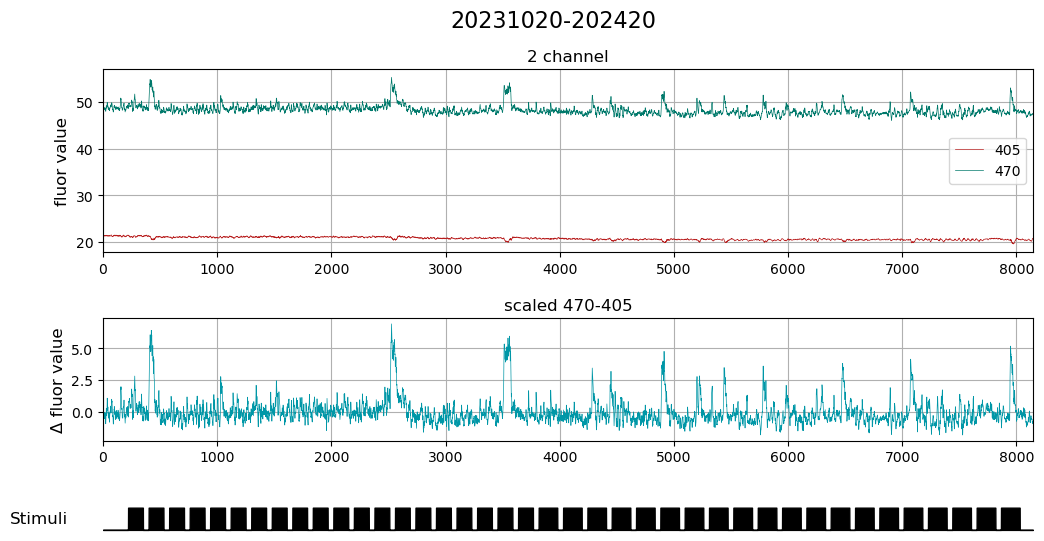

finish plotting 20231020-202420

path: Z:\WF_VC_liuzhaoxi\23.10.20_G360_gp4.3\rf68
experiments: ['20231020-204235']


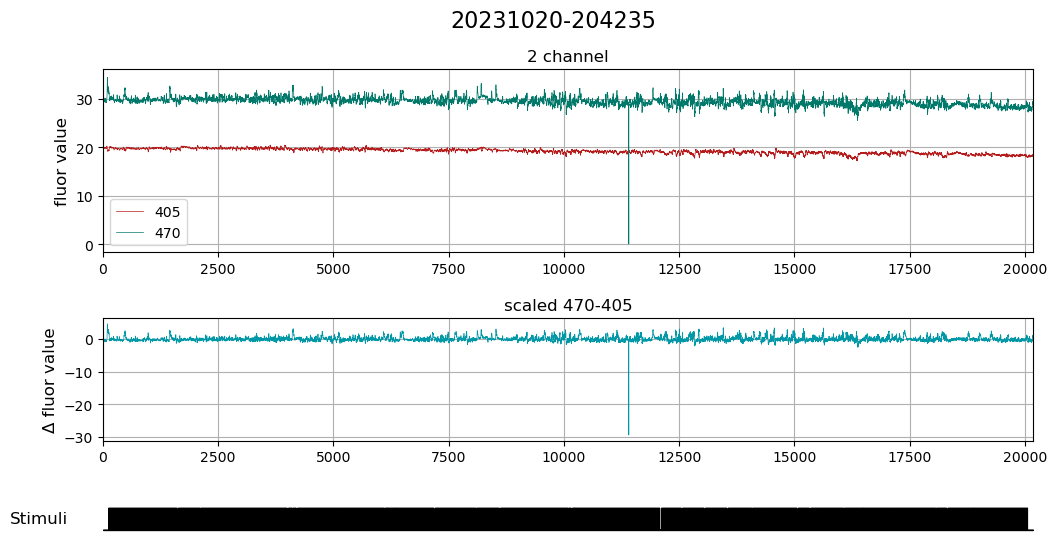

finish plotting 20231020-204235


All plotting finished!


In [4]:
### plot mean values

for path in path_all:
    print('\npath:',path)
    rawPath = pjoin(path, "raw")
    
    # 列出experiments
    items = os.listdir(rawPath)
    experiments = list(set([item[:15] for item in items if os.path.isdir(pjoin(rawPath, item))]))
    print("experiments:",experiments)
    
    # 遍历每个experiment
    for experiment in experiments:
        plotFluor(path, experiment)
        print("finish plotting "+experiment)
        
        
print("\n\nAll plotting finished!")

In [15]:
### 生成trial_onsets.npy

nbaseline_frames = 30 #预留的刺激前frames，用来计算baseline

for path in path_all:
    rawPath = pjoin(path, "raw")
    processPath = pjoin(path, "process")
    # 列出experiments
    items = os.listdir(rawPath)
    experiments = list(set([item[:15] for item in items if os.path.isdir(pjoin(rawPath, item))]))
    # 遍历每个experiment
    for experiment in experiments:
        os.makedirs(pjoin(processPath, experiment+"-merged"), exist_ok=True)
        mergePath = pjoin(processPath, experiment+"-merged")
        
        # generate trial_onsets.npy
        # trial_onsets.npy is a Nx3 array. The columns are: trial number, onset of the trial (frame index), offset of the trial.
        if not os.path.exists(pjoin(mergePath, 'trial_onsets.npy')):
            n_frame = min(len(os.listdir(pjoin(rawPath, experiment + "-405"))), len(os.listdir(pjoin(rawPath, experiment + "-470"))))
            stimfile = pd.read_csv(pjoin(rawPath, experiment + ".csv"), header=None).values
            stim_delay = pd.read_csv(pjoin(rawPath, experiment + "-470Timestamp.csv"), header=None).values
            stim_delay = int(stim_delay[0]/10)
            stim = np.zeros(n_frame)
            for i in range(n_frame):
                stim[i] = stimfile[(i * 10 + stim_delay), 0]
            
            onset = np.where(np.diff(stim) == 1)[0] + 1
            offset = np.where(np.diff(stim) == -1)[0] + 1
            trial_onsets = np.stack((np.arange(len(onset)), onset - nbaseline_frames, offset), axis=1)  # 这个文件给wfield软件做SVD用
            np.save(pjoin(mergePath, 'trial_onsets.npy'), trial_onsets)
            trials_csv = np.stack((np.arange(len(onset)), onset, offset, offset-onset), axis=1)  # 这个用来自己检查一下以及自己后续分析
            np.savetxt(pjoin(mergePath, "trials.csv"), trials_csv, delimiter=",")
            print("generate trial_onsets.npy of "+experiment)
        else: print("trial_onsets.npy of "+experiment+" has existed")
            
print("\nAll generation of trials-file finished!")


generate trial_onsets.npy of 20231020-202420

All generation of trials-file finished!


In [24]:
### merge channels

for path in path_all:
    print("Path: "+ path)
    rawPath = pjoin(path, "raw")
    processPath = pjoin(path, "process")

    # 列出experiments
    items = os.listdir(rawPath)
    experiments = list(set([item[:15] for item in items if os.path.isdir(pjoin(rawPath, item))]))
    print("experiments:")
    print(experiments)
    
    # 遍历每个experiment
    for experiment in experiments:
        os.makedirs(pjoin(processPath, experiment+"-merged"), exist_ok=True)
        mergePath = pjoin(processPath, experiment+"-merged")

        # merge channels
        merge_file = pjoin(mergePath, experiment+"-merged.tif")
        if not os.path.exists(merge_file):
            tif_405 = imread(pjoin(processPath, experiment + "-405.tif"))
            tif_470 = imread(pjoin(processPath, experiment + "-470.tif"))
            # 检查两个通道的深度是否一致
            if tif_405.shape[0] != tif_470.shape[0]:
                n_frames = min(tif_405.shape[0], tif_470.shape[0])
                tif_405 = tif_405[:n_frames]
                tif_470 = tif_470[:n_frames]
            # 将Tiff stack的数据从三维变成四维，不同通道使用第二维区分
            merged_tif = np.concatenate((tif_470[:, np.newaxis], tif_405[:, np.newaxis]), axis=1)
            # 将合并后的图像保存为一个2通道Tiff图像
            imwrite(merge_file, merged_tif, imagej=True)
            print("finish merging "+experiment)
        else: print("merged "+experiment+" has existed")
    print("\nfinished "+ path+"\n\n")
    
print("All merging finished!")


Path: Z:\WF_VC_liuzhaoxi\23.10.20_G360_gp4.3\retinotopy_10x4
experiments:
['20231020-202420']
merged 20231020-202420 has existed

finished Z:\WF_VC_liuzhaoxi\23.10.20_G360_gp4.3\retinotopy_10x4


Path: Z:\WF_VC_liuzhaoxi\23.10.20_G360_gp4.3\rf68
experiments:
['20231020-204235']
finish merging 20231020-204235

finished Z:\WF_VC_liuzhaoxi\23.10.20_G360_gp4.3\rf68


All merging finished!


### ********************************************************************************************************************
### 从这里开始用wfield软件做运动矫正、奇异值分解、血流动力学矫正。以下必须用wfield环境！！！
### ********************************************************************************************************************

In [5]:
%matplotlib inline
from glob import glob
import os
from os.path import join as pjoin
import subprocess
from wfield_utils import *

In [6]:
# try wfield

! wfield -h

usage: wfield <command> [<args>]

The commands are:
    ncaas               Opens a gui to launch data on the neuroCAAS platform
    open                Opens a gui to look at the preprocessed data        
    open_raw            Opens a gui to look at the raw frames
    preprocess          Preprocess data in binary fornat
    motion              Registers data from a binary file
    decompose           Performs single value decomposition
    correct             Performs hemodynamic correction on dual channel data
    imager              
    imager_preprocess   Preprocesses data recorded with the WidefieldImager

wfield - tools to process widefield data

positional arguments:
  command     type wfieldtools <command> -h for help

options:
  -h, --help  show this help message and exit


In [6]:
# 列出所有已经合并通道的tiff的路径

# path_0 = "Z:\\WF_VC_liuzhaoxi\\23.9.22_G360_gp4.3"
path_merge_all = glob(pjoin(path_0, '*\\process\\*-merged'))
print('All the merge-path:\n'+"\n".join(path_merge_all))


All the merge-path:
Z:\WF_VC_liuzhaoxi\23.10.20_G360_gp4.3\retinotopy_10x4\process\20231020-202420-merged
Z:\WF_VC_liuzhaoxi\23.10.20_G360_gp4.3\rf68\process\20231020-204235-merged


In [7]:
# 用wfield进行Motion correction, single value decomposition, hemodynamic correction。

# nbaseline_frames = 30 

for path_merge in path_merge_all:
    if len(glob(pjoin(path_merge, '*-merged.tif'))) == 0:
        print(path_merge,"can't find merged tiff file！\n")
    elif len(glob(pjoin(path_merge, '*-merged.tif'))) > 1:
        print(path_merge,"exist multiple merged tiff file！\n")
    elif os.path.exists(pjoin(path_merge, 'SVTcorr.npy')):
        print(path_merge,'analysis has been finished！\n')
    else:
        print('Start analyze',path_merge)
        command = "wfield preprocess --nchannels 2 --nbaseline-frames {} --functional-channel 0 --fs 10 -o {} {}".format(nbaseline_frames,path_merge,path_merge)
        logfile = pjoin(path_merge, 'log.txt')
        with open(logfile, "w") as log:
            result = subprocess.run(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
            log.write(result.stdout)
        if result.returncode == 0:
            print('Finish analyzing',path_merge,'\n')
        else:
            print('！！！Error occured when analyzing',path_merge,'\n')
        
print('\nMotion correction, single value decomposition, hemodynamic correction. All finished!')


Start analyze Z:\WF_VC_liuzhaoxi\23.10.20_G360_gp4.3\retinotopy_10x4\process\20231020-202420-merged
Finish analyzing Z:\WF_VC_liuzhaoxi\23.10.20_G360_gp4.3\retinotopy_10x4\process\20231020-202420-merged 

Start analyze Z:\WF_VC_liuzhaoxi\23.10.20_G360_gp4.3\rf68\process\20231020-204235-merged
Finish analyzing Z:\WF_VC_liuzhaoxi\23.10.20_G360_gp4.3\rf68\process\20231020-204235-merged 


Motion correction, single value decomposition, hemodynamic correction. All finished!


In [ ]:
# 重构矫正后图像

export_corr_tif = False

if export_corr_tif is True:
    for path_merge in path_merge_all:
        print('\npath', path_merge)
        filename = os.path.basename(glob(pjoin(path_merge, '*-merged.tif'))[0])[:16]
        if not (os.path.exists(pjoin(path_merge, filename+"SVD_corr.tif")) or os.path.exists(pjoin(path_merge, filename+"SVD_corr_uint16.tif")) or os.path.exists(pjoin(path_merge, filename+"hemo-corr.tif"))):
            svd2tif(path_merge, name=filename, uint16=False, corr470=False)
        else:
            print('reconstruction has been finished！')
        
    print('\n\nAll image reconstruction finished!')


Finish exporting trial-average tif


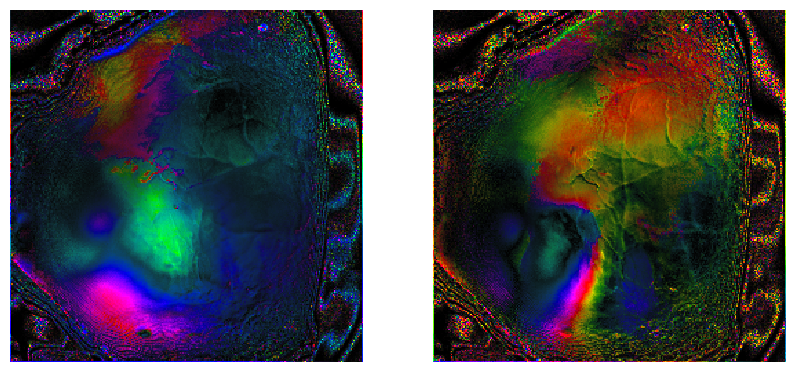

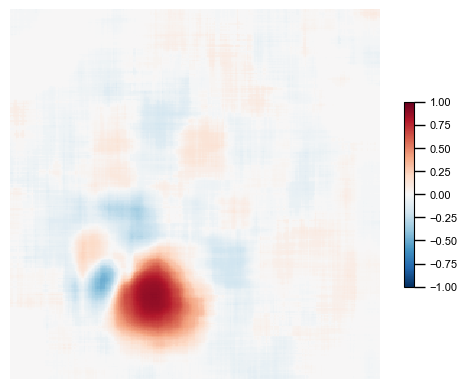

In [7]:
phasemap('Z:\\WF_VC_liuzhaoxi\\23.10.20_G360_gp4.3\\retinotopy_10x4\\process\\20231020-202420-merged', nrepeats=10, post_trial=3, export_ave_tif=True, export_phase=True)
